# 基于机器学习的自杀分析与预测

In [1]:
#导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
plt.rcParams['font.sans-serif']='fangsong'
plt.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 导入原始自杀数据集并重新命名列：

originaldata = pd.read_csv('./master.csv')

# 国家，  年份，  性别，  年龄，  自杀人数，  人口数量，  自杀人数/总人口*100000（自杀率），
# 国家-年份，     人类发展指数（用以衡量联合国各成员国经济社会发展水平的指标，是对传统的GNP指标挑战的结果。）
# 年度国内生产总值(衡量经济发展的指标)，      年人均国内生产总值：国内生产总值/人口 ，         世代
originaldata.columns = ['country', 'year', 'sex', 'age', 'suicides_no', 'population','suicidesper100k',
                      'country-year', 'yearlyHDI', 
                        'GDPpyear', 'GDPpcapita', 'generation']

originaldata.head()

,country,year,sex,age,suicides_no,population,suicidesper100k,country-year,yearlyHDI,GDPpyear,GDPpcapita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [3]:
# 修复和清理原始数据

# 将 年度国内生产总值 数据中 ','分割去除掉（比如2,156,624,900），并且转换成float的数字类型
originaldata['GDPpyear'] = originaldata.apply(lambda x: float(x['GDPpyear'].replace(',', '')), axis=1)
originaldata['GDPpyear'].head(10)

0    2.156625e+09
1    2.156625e+09
2    2.156625e+09
3    2.156625e+09
4    2.156625e+09
5    2.156625e+09
6    2.156625e+09
7    2.156625e+09
8    2.156625e+09
9    2.156625e+09
Name: GDPpyear, dtype: float64

In [4]:
# sex 转换为category类型
# Categoricals 是 pandas 的一种数据类型，对应着被统计的变量。Categoricals 是由固定的且有限数量的变量组成的。
originaldata.sex.astype('category')

0          male
1          male
2        female
3          male
4          male
5        female
6        female
7        female
8          male
9        female
10       female
11         male
12       female
13         male
14         male
15         male
16         male
17       female
18       female
19       female
20         male
21       female
22       female
23         male
24         male
25         male
26         male
27         male
28         male
29       female
          ...  
27790    female
27791    female
27792      male
27793    female
27794    female
27795    female
27796      male
27797      male
27798    female
27799      male
27800      male
27801      male
27802    female
27803    female
27804    female
27805      male
27806    female
27807    female
27808      male
27809      male
27810    female
27811      male
27812      male
27813      male
27814    female
27815    female
27816    female
27817      male
27818    female
27819    female
Name: sex, Length: 27820

In [5]:
# 导入额外功能的自杀数据集：
extra_data = pd.read_csv('./suicidedataextrafestures.csv')

# 国家，   年份，   性别，   年龄，    自杀人数，    人口数量，
# 自杀人数/总人口*100000（自杀率），   国家-年份，   人类发展指数（用以衡量联合国各成员国经济社会发展水平的指标，是对传统的GNP指标挑战的结果。）
# 年度国内生产总值(衡量经济发展的指标) ，    年人均国内生产总值：国内生产总值/人口
# 世代， 自杀率，  使用互联网的个人(占人口的百分比)，     费用(占国内生产总值的百分比)，    雇员补偿（工资）(占开支的百分比)
# 失业总人数(占劳动力总数的百分比)，   医生(每1 000人)，    法律权利指数的强弱(0=弱至12=强)，   劳动力总数
# 预期寿命，总计(年)，        移动电话订阅(每100人)
# 按原籍国或领土分列的难民人口，    贡献型家庭工人总人数(占总就业人数的百分比)(模拟劳工组织估计数)
# 获得电力(占人口的百分比)，        中学毕业率，共计(占相关年龄组的百分比)
extra_data.columns = [
    'country', 'year', 'sex', 'age', 'suicides_no', 'population',
    'suicidesper100k', 'country-year', 'yearlyHDI',
    'GDPpyear', 'GDPpcapita', 
    'generation', 'suicide%', 'Internetusers', 'Expenses', 'employeecompensation',
    'Unemployment', 'Physiciansp1000', 'Legalrights', 'Laborforcetotal',
    'Lifeexpectancy', 'Mobilesubscriptionsp100',
    'Refugees', 'Selfemployed', 
    'electricityacess', 'secondarycompletion']

In [6]:
extra_data.head()

,country,year,sex,age,suicides_no,population,suicidesper100k,country-year,yearlyHDI,GDPpyear,...,Unemployment,Physiciansp1000,Legalrights,Laborforcetotal,Lifeexpectancy,Mobilesubscriptionsp100,Refugees,Selfemployed,electricityacess,secondarycompletion
0,Argentina,1985,male,75+ years,202,363000,55.65,Argentina1985,0.694,8.841667e+10,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,Argentina,1985,male,55-74 years,485,1997000,24.29,Argentina1985,0.694,8.841667e+10,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,Argentina,1985,male,35-54 years,414,3346300,12.37,Argentina1985,0.694,8.841667e+10,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,Argentina,1985,female,55-74 years,210,2304000,9.11,Argentina1985,0.694,8.841667e+10,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
4,Argentina,1985,male,25-34 years,177,2234200,7.92,Argentina1985,0.694,8.841667e+10,...,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


原始数据集包含1985-2016年期间来自100多个国家的数据。我决定限制国家数量，使分析更具洞察力。我选择了来自世界不同地区的40多个国家，我认为这些国家是不同地区的一个很好的样本。

In [7]:
countrynames = [
    'Argentina',         #阿根廷
    'Armenia',           #亚美尼亚
    'Australia',         #澳大利亚
    'Austria',           #奥地利
    'Belgium',           #比利时
    'Brazil',            #巴西
    'Bulgaria',          #保加利亚
    'Canada',            #加拿大
    'Chile',             #智利
    'Colombia',          #哥伦比亚
    'Croatia',           #克罗地亚
    'Cuba',              #古巴
    'Czech Republic',    #捷克共和国
    'Denmark',           #丹麦
    'Finland',           #芬兰
    'France',            #法国
    'Germany',           #德国
    'Greece',            #希腊
    'Hungary',           #匈牙利
    'Iceland',           #冰岛
    'Ireland',           #爱尔兰
    'Israel',            #以色列
    'Italy',             #意大利
    'Japan',             #日本
    'Mexico',            #墨西哥
    'Netherlands',       #Netherlands
    'New Zealand',       #新西兰
    'Norway',            #挪威
    'Poland',            #波兰
    'Portugal',          #葡萄牙
    'Romania',           #罗马尼亚
    'Russian Federation',#俄罗斯
    'South Africa',      #南非
    'Spain',             #西班牙
    'Sweden',            #瑞典
    'Switzerland',       #瑞士
    'Thailand',          #泰国
    'Turkmenistan',      #土库曼斯坦
    'Ukraine',           #乌克兰
    'United Kingdom',    #联合王国
    'United States']     #美国

In [8]:
#另外，来自WDI数据库的额外数据中1985年到1994年和2014年的数据空白太多，只能用1995-2013年的数据，因此我决定将数据限制在这段时间内。

df1 = extra_data.copy()

In [9]:
df1 = extra_data.copy()
# 阿根廷的一系列数据
df = df1.iloc[np.where(df1.country == countrynames[0])] 
for i, x in enumerate(countrynames[1:]):
    df = df.append(df1.iloc[np.where(df1.country == x)])  #添加剩余的国家数据
    
df = df[df.year >= 1995] #用 1995-2013年的数据  
df = df[df.year <= 2013]
df.head(100000000)

,country,year,sex,age,suicides_no,population,suicidesper100k,country-year,yearlyHDI,GDPpyear,...,Unemployment,Physiciansp1000,Legalrights,Laborforcetotal,Lifeexpectancy,Mobilesubscriptionsp100,Refugees,Selfemployed,electricityacess,secondarycompletion
120,Argentina,1995,male,75+ years,190,433800,43.80,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651000,1.163986,330.0,1.409,NaN,NaN
121,Argentina,1995,male,55-74 years,515,2214000,23.26,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651000,1.163986,330.0,1.409,NaN,NaN
122,Argentina,1995,male,35-54 years,485,3787800,12.80,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651000,1.163986,330.0,1.409,NaN,NaN
123,Argentina,1995,male,25-34 years,218,2404900,9.06,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651000,1.163986,330.0,1.409,NaN,NaN
124,Argentina,1995,male,15-24 years,277,3112100,8.90,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651000,1.163986,330.0,1.409,NaN,NaN
125,Argentina,1995,female,75+ years,49,742200,6.60,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651000,1.163986,330.0,1.409,NaN,NaN
126,Argentina,1995,female,55-74 years,134,2625900,5.10,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651000,1.163986,330.0,1.409,NaN,NaN
127,Argentina,1995,female,35-54 years,139,3950100,3.52,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651000,1.163986,330.0,1.409,NaN,NaN
128,Argentina,1995,female,15-24 years,101,3053300,3.31,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651000,1.163986,330.0,1.409,NaN,NaN
129,Argentina,1995,female,25-34 years,62,2396900,2.59,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651000,1.163986,330.0,1.409,NaN,NaN


# 数据探索

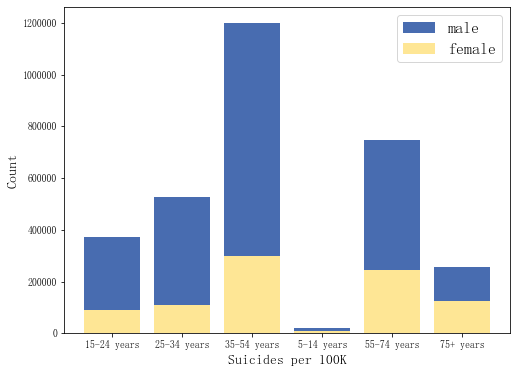

In [60]:
col = plt.cm.Spectral(np.linspace(0, 1, 20))

plt.figure(figsize=(8, 6))

agedistf = pd.DataFrame(df.groupby('sex').get_group('female').groupby('age').suicides_no.sum())

agedistm = pd.DataFrame(df.groupby('sex').get_group('male').groupby('age').suicides_no.sum())

plt.bar(agedistm.index, agedistm.suicides_no, color=col[18])
plt.bar(agedistf.index, agedistf.suicides_no, color=col[8])
plt.legend(['male', 'female'], fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Suicides per 100K', fontsize=14)
plt.show()

**总体看下来，不管是哪个年龄段，男性的自杀率都要比女性高。
  尤其是25-34岁以及35-54岁年龄段是自杀的高峰期，男女自杀率接近于3：1，而原因是因为工作和生活压力较大，家庭、情感以及经济问题会导致精神崩溃，很容易走上绝路。这是个紧迫而又严肃的问题，不仅要重视身体健康更要重视精神健康。
  其次是55-74岁，55岁以上的老年人也已经成为自杀率很高的人群，多是因为孤独而导致抑郁。此外，与子女的矛盾、生理机能丧失也是导致老人抑郁自杀的原因
  而15-24岁的青少年也是自杀高危年龄段，这可能是由于青年人学业的压力以及开始走出校园走向工作岗位，并尝试独立生活而又缺乏生活经验，同时又要面临成家立业的巨大压力所导致的。**

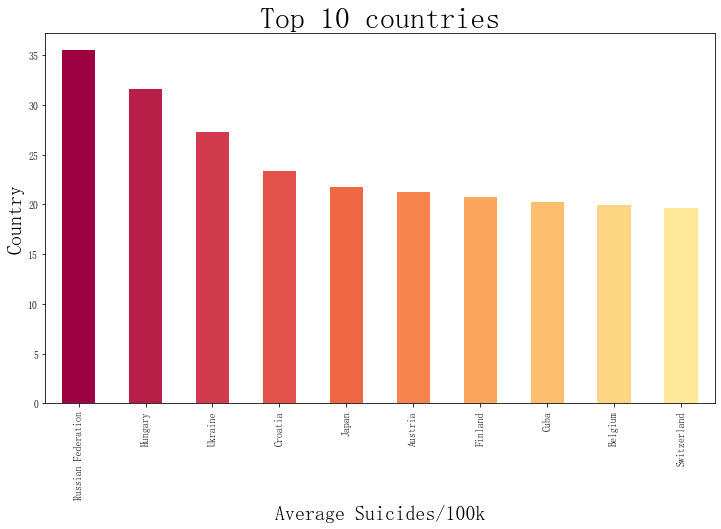

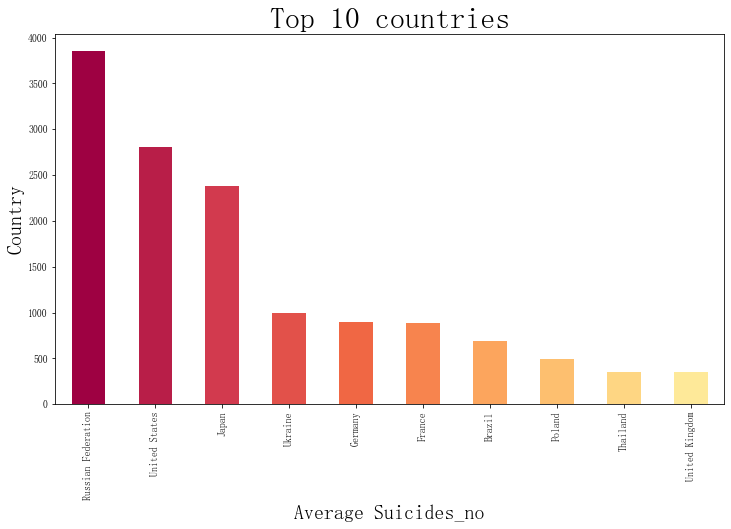

In [11]:
col = plt.cm.Spectral(np.linspace(0, 1, 22))
plt.figure(figsize=(12, 15))

plt.subplot(211)
#自杀率（放大1000倍）的平均值最高的前10个国家
df.groupby(['country']).suicidesper100k.mean().nlargest(10).plot(kind='bar', color=col) 
plt.xlabel('Average Suicides/100k', size=20)
plt.ylabel('Country', fontsize=20)
plt.title('Top 10 countries', fontsize=30)

plt.figure(figsize=(12, 15))

plt.subplot(212)
#自杀人数的平均值最高的前10个国家
df.groupby(['country']).suicides_no.mean().nlargest(10).plot(kind='bar', color=col)
plt.xlabel('Average Suicides_no', size=20)
plt.ylabel('Country', fontsize=20);
plt.title('Top 10 countries', fontsize=30)
plt.show()

**自杀率排在前10的国家为 俄罗斯（欧洲）、 匈牙利（欧洲）、乌克兰（欧洲）、 克罗地亚 （欧洲）、日本（亚洲）、澳大利亚 （大洋洲）、芬兰 （欧洲）、古巴 （美洲）、比利时（欧洲）、 瑞士（欧洲）**

**自杀人数排前10的国家为 俄罗斯（欧洲）、美国（美洲）、日本（亚洲）、乌克兰（欧洲）、德国（欧洲）、法国（欧洲）、 巴西（美洲）、波兰（欧洲）、泰国 （亚洲）、英国（欧洲）**

 **可以发现欧洲国家的自杀人数和自杀率都非常高，例如俄罗斯、乌克兰、英国等。
 也可以发现俄罗斯、日本等国家高居自杀率都偏高，这些国家是GDP、就业、奢侈品等方面最强大的国家，并且经济实力也位于世界前列，而导致自杀率高的一个客观原因是人口基数大，主观原因可能是生活节奏飞快，生活代价很高,失业率严重、人际关系紧张等。**

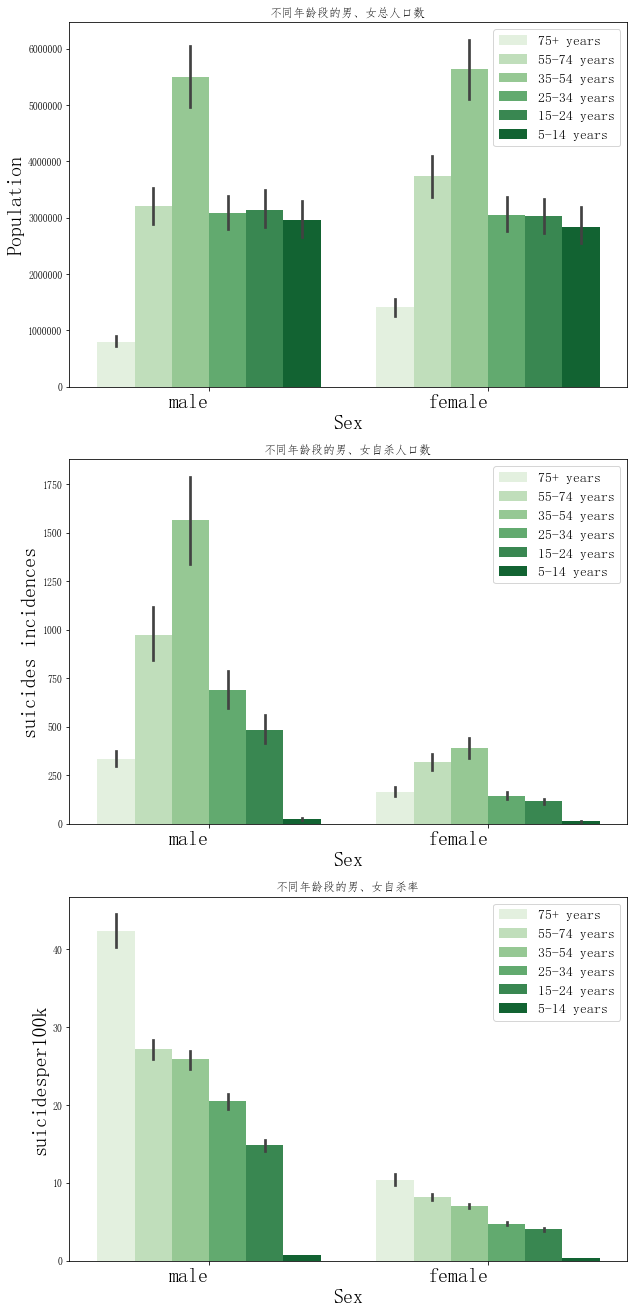

In [12]:
plt.figure(figsize=(10, 16))

#总人口的各个年龄段的性别分布
plt.subplot(311)
sns.barplot(x='sex', y='population', hue='age', data=df, palette="Greens")  #hue按年龄分组
plt.xticks(ha='right', fontsize=20)
plt.ylabel('Population', fontsize=20)
plt.xlabel('Sex', fontsize=20)
plt.title("不同年龄段的男、女总人口数")
plt.legend(fontsize=14, loc='best')

#自杀人数的各个年龄段的性别分布
plt.subplot(312)
sns.barplot(x='sex', y='suicides_no', hue='age', data=df, palette="Greens")
plt.xticks(ha='right', fontsize=20)
plt.ylabel('suicides incidences', fontsize=20)
plt.xlabel('Sex', fontsize=20)
plt.title("不同年龄段的男、女自杀人口数")
plt.legend(fontsize=14)

#自杀率（放大1000倍）的各个年龄段的性别分布
plt.subplot(313)
sns.barplot(x='sex', y='suicidesper100k', hue='age', data=df,palette="Greens")
plt.xticks(ha='right', fontsize=20);
plt.ylabel('suicidesper100k',fontsize=20);
plt.xlabel('Sex',fontsize=20);
plt.title("不同年龄段的男、女自杀率")
plt.legend(fontsize=14);

plt.subplots_adjust(top=1.2)
plt.show()

图1为 各个不同年龄段的男、女总人口数据柱状图。
  就总人口而言 各个年龄段的男女比例差不多。

图2为 各个不同年龄段的男、女自杀人口数据柱状图。
  可以很明显的看出男性的自杀人数远远大于女性自杀人数。
其可能的原因男性所承受的压力要多于女性，精神方面会变得脆弱，并会导致身体不健康以及精神不健康。

图3为 各个不同年龄段的男、女自杀率人口数据柱状图。
  就75+，也就是老年阶段，从侧面也反映出老龄化的问题。
在老龄化进程加速的状况下，社会保障体系和社会经济文化的发展难以满足老年人的物质和精神需求，
多重矛盾造就了本该安享晚年的老年人，出现了比年轻人更严重的生存和精神压力。
  所以，老年人的生存现状需要受到重视，应该不断出台老年人的保障措施，来保障老年人的老年生活。

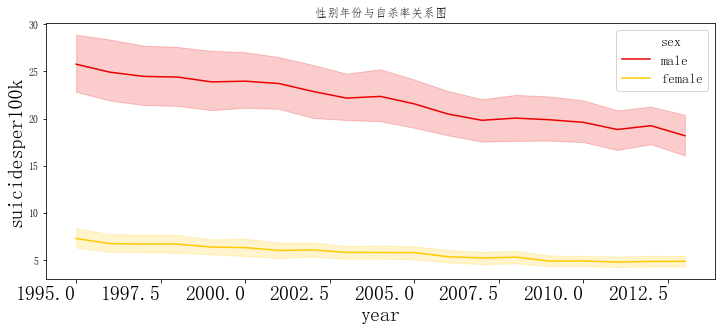

In [13]:
plt.figure(figsize=(12, 16))

# 具体按性别和年份 来看 男女的自杀率
plt.subplot(311)
sns.lineplot(x='year', y='suicidesper100k', hue='sex', data=df, palette="hot")  #hue按年龄分组
plt.xticks(ha='right', fontsize=20)
plt.ylabel('suicidesper100k', fontsize=20)
plt.xlabel('year', fontsize=20)
plt.legend(fontsize=14, loc='best')  
plt.title("性别年份与自杀率关系图")
plt.show()

图为 具体按性别和年份 来看 男女的自杀率
1995年-2013年男性自杀率远远大于女性。
女性自杀率水平在0.005%左右，男性自杀率水平在0.02%左右，男性自杀率约是女性的4倍。从时间来看，在这区间，全球范围综合自杀率并没有出现明显的下降

结合分析，在全球范围内，男性自杀率高于女性，约为女性自杀率的4倍左右。在现代社会中男性承担的社会责任相对较大，相应的压力也会增加。所以一个国家应该关注于提升人民生活质量，健全保障体系。在每个家庭面对突发的困难是能够提供一定的保障，例如失业，生病，意外事故等。

全球范围内，年龄越大的人群自杀率相对较高。在现在全球人口老龄化的趋势下，这种情况无疑更加严峻。关于老年人群的生活的物质条件需要改善，其心理更需要梳理与关注。

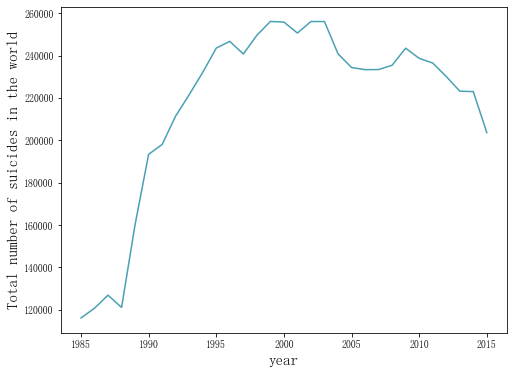

In [14]:
plt.figure(figsize=(8, 6))

#选出year列并且去除重复的年份
year = originaldata.groupby('year').year.unique()

#各个年份的自杀人数汇总
#使用seaborn进行可视化,输入的数据必须为dataframe
totalpyear = pd.DataFrame(originaldata.groupby('year').suicides_no.sum())   

plt.plot(year.index[0:31], totalpyear[0:31], color=col[18])  #选取范围为[0:31]  1985年到2015年
plt.xlabel('year', fontsize=15)
plt.ylabel('Total number of suicides in the world', fontsize=15)
plt.show()

世界自杀人数趋势2000年之前逐步上升，2000年后呈现缓慢下降趋势
在2000年之前，人们所处的地区条件乏善可陈，人群受教育程度偏低，社会动荡，经济发展水平不高。
之后，随着科技的进步以及社会经济不断发展，社会更加安稳。混乱、贫穷、饥饿的现象变少，人们的的焦虑有改善。各国政府在医疗保健上的投入和家庭护理的提升也会使自杀趋势降低。

In [15]:
# 观察各年份的自杀总数
originaldata.groupby('year').suicides_no.sum().head(50)

year
1985    116063
1986    120670
1987    126842
1988    121026
1989    160244
1990    193361
1991    198020
1992    211473
1993    221565
1994    232063
1995    243544
1996    246725
1997    240745
1998    249591
1999    256119
2000    255832
2001    250652
2002    256095
2003    256079
2004    240861
2005    234375
2006    233361
2007    233408
2008    235447
2009    243487
2010    238702
2011    236484
2012    230160
2013    223199
2014    222984
2015    203640
2016     15603
Name: suicides_no, dtype: int64

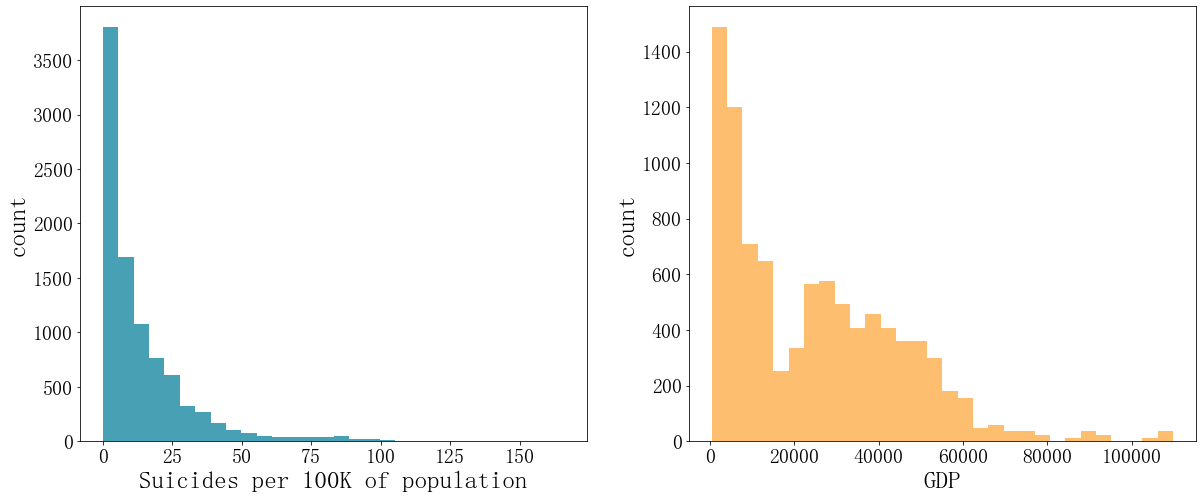

In [16]:
# 直方图是为了表明数据分布情况。通俗地说就是哪一块数据所占比例或者出现次数较高，哪一块出现概率低。
plt.figure(figsize=(20, 8))

# 自杀率（放大1000倍）的分布情况，y轴为个数
plt.subplot(121)
plt.hist(df.suicidesper100k, bins=30, color=col[18])   #bins:条形数
plt.xlabel('Suicides per 100K of population', fontsize=25)
plt.xticks(rotation = 0,                 fontsize = 20)  
plt.ylabel('count', fontsize=25)
plt.yticks(                              fontsize = 20)   

# 年人均国内生产总值的分布情况，y轴为个数
plt.subplot(122)
plt.hist(df.GDPpcapita, bins=30, color=col[7])
plt.xlabel('GDP', fontsize=25)
plt.xticks(rotation = 0,fontsize = 20)  
plt.ylabel('count', fontsize=25)
plt.yticks(fontsize = 20)   
plt.show()

In [17]:
# 直观看出df内的数据
df.head(50)

,country,year,sex,age,suicides_no,population,suicidesper100k,country-year,yearlyHDI,GDPpyear,...,Unemployment,Physiciansp1000,Legalrights,Laborforcetotal,Lifeexpectancy,Mobilesubscriptionsp100,Refugees,Selfemployed,electricityacess,secondarycompletion
120,Argentina,1995,male,75+ years,190,433800,43.80,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651,1.163986,330.0,1.409,NaN,NaN
121,Argentina,1995,male,55-74 years,515,2214000,23.26,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651,1.163986,330.0,1.409,NaN,NaN
122,Argentina,1995,male,35-54 years,485,3787800,12.80,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651,1.163986,330.0,1.409,NaN,NaN
123,Argentina,1995,male,25-34 years,218,2404900,9.06,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651,1.163986,330.0,1.409,NaN,NaN
124,Argentina,1995,male,15-24 years,277,3112100,8.90,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651,1.163986,330.0,1.409,NaN,NaN
125,Argentina,1995,female,75+ years,49,742200,6.60,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651,1.163986,330.0,1.409,NaN,NaN
126,Argentina,1995,female,55-74 years,134,2625900,5.10,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651,1.163986,330.0,1.409,NaN,NaN
127,Argentina,1995,female,35-54 years,139,3950100,3.52,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651,1.163986,330.0,1.409,NaN,NaN
128,Argentina,1995,female,15-24 years,101,3053300,3.31,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651,1.163986,330.0,1.409,NaN,NaN
129,Argentina,1995,female,25-34 years,62,2396900,2.59,Argentina1995,0.731,2.580320e+11,...,18.799999,2.6800,NaN,14979213,72.651,1.163986,330.0,1.409,NaN,NaN


**这里分析的国家大部分都属于欧洲及美洲
可以看出自杀率都集中在0到0.025%区间
而人均国内生产总值(美元) 都集中在15000-50000美元区间，而这一指标也会影响自杀率的大小**

In [18]:
# 查找原数据集的缺失情况
print('数据集缺失情况如下：\r\n列名     |   缺失数量\r\n{}'.format(df.isnull().sum()))

数据集缺失情况如下：
列名     |   缺失数量
country                       0
year                          0
sex                           0
age                           0
suicides_no                   0
population                    0
suicidesper100k               0
country-year                  0
yearlyHDI                  5952
GDPpyear                      0
GDPpcapita                    0
generation                    0
suicide%                      0
Internetusers                84
Expenses                   1152
employeecompensation       1200
Unemployment                  0
Physiciansp1000            2148
Legalrights                8760
Laborforcetotal               0
Lifeexpectancy                0
Mobilesubscriptionsp100       0
Refugees                    132
Selfemployed                  0
electricityacess            312
secondarycompletion        5412
dtype: int64


# 特征的选择

**从上面的探索性分析可以看出影响是否自杀重要的特征，所以我选取其中11个特性进行探索。因为这些特征基本上是缺失值较少且具有代表性。**

总体特征：“国家”、“年份”、“年国内生产总值(美元)”、“人均国内生产总值(美元)”、“雇员补偿(占开支的百分比)”、“失业总人数(占劳动力总数的百分比)”、“预期寿命”、“难民人口”、“自营职业者人数(占总就业人数的百分比)”、“使用互联网的个人(占人口的百分比)”、“人口数量”。

我也要提取性别和年龄组的关系。创建一个新的data frame“total”，新的栏“自杀”作为自杀率的总数值，通过对性别和年龄组的总和计算。

In [19]:
# 选取总体特征：“国家”、“年份”、“年GDP”、“年人均GDP”、“雇员补偿%”、“失业总人数%”、
#“预期寿命”、“难民人口”、“自营职业者人数%”、“互联网用户%”
features = ['country', 'year', 'GDPpyear', 'GDPpcapita', 'employeecompensation', 'Unemployment',
            'Lifeexpectancy', 'Refugees', 'Selfemployed', 'Internetusers']

# total的数据为 按照国家分类，匹配countrynames的第0个的国家，并且按year获取均值
total = df[features].groupby('country').get_group(countrynames[0]).groupby('year').mean()

# 新加一列‘Suicides’，第0个国家每年的自杀率（扩大1000倍）
total['Suicides'] = df[['country', 'year', 'suicidesper100k']].groupby('country').get_group(countrynames[0]).groupby('year').sum()

# 新加一列‘population’，第0个国家每年的总人口数
total['population'] = df[['country', 'year', 'population']].groupby('country').get_group(countrynames[0]).groupby('year').sum()

# 新加一列‘country’，为第0个国家
total['country'] = countrynames[0]

#将之后国家的数据添加到total后
#取第0后面的第1到最后的国家数据
for i, x in enumerate(countrynames[1:]):
    suicides = df[features].groupby('country').get_group(x).groupby('year').mean()
    suicides['Suicides'] = df[['country', 'year', 'suicidesper100k']].groupby('country').get_group(x).groupby('year').sum()
    suicides['population'] = df[['country', 'year', 'population']].groupby('country').get_group(x).groupby('year').sum()
  
    suicides['country'] = x
    total = total.append(suicides)

total.reset_index(inplace=True)   # 不创建新对象 直接对原始对象进行修改
sort = True

total.head(100)

,year,GDPpyear,GDPpcapita,employeecompensation,Unemployment,Lifeexpectancy,Refugees,Selfemployed,Internetusers,Suicides,population,country
0,1995,2.580320e+11,8232,17.243447,18.799999,72.651000,330.0,1.409000,0.086277,119.97,31345400,Argentina
1,1996,2.721500e+11,8563,16.401037,17.110001,72.843000,217.0,1.665000,0.141955,118.03,31780700,Argentina
2,1997,2.928590e+11,9057,16.412140,14.820000,73.029000,159.0,1.541000,0.280340,111.40,32333781,Argentina
3,1998,2.989480e+11,9126,15.014755,12.650000,73.213000,142.0,1.326000,0.830767,116.93,32757259,Argentina
4,1999,2.835230e+11,8546,15.078509,14.050000,73.396000,586.0,1.355000,3.284482,117.19,33174862,Argentina
5,2000,2.842040e+11,8462,14.694699,15.000000,73.576000,609.0,1.154000,7.038683,131.39,33585533,Argentina
6,2001,2.686970e+11,7900,14.238719,17.320000,73.755000,659.0,1.092000,9.780807,143.56,34010946,Argentina
7,2002,9.772400e+10,2840,11.344743,19.590000,73.932000,771.0,1.114000,10.882124,139.42,34407507,Argentina
8,2003,1.275870e+11,3668,11.670367,15.360000,74.107000,784.0,1.657000,11.913697,146.29,34785907,Argentina
9,2004,1.646580e+11,4683,11.506018,13.522000,74.280000,796.0,1.308000,16.036684,131.06,35162945,Argentina


In [20]:
#totalfeatures：“国家”、“年份”、“年GDP”、“年人均GDP”、“雇员补偿%”、“失业总人数%”、
#“预期寿命”、“难民人口”、“自营职业者人数%”、“互联网用户%”、“人口数量”。
totalfeatures = ['country', 'year', 'GDPpyear', 'GDPpcapita', 'employeecompensation', 'Unemployment',
                 'Lifeexpectancy', 'Refugees', 'Selfemployed', 'Internetusers', 'population']

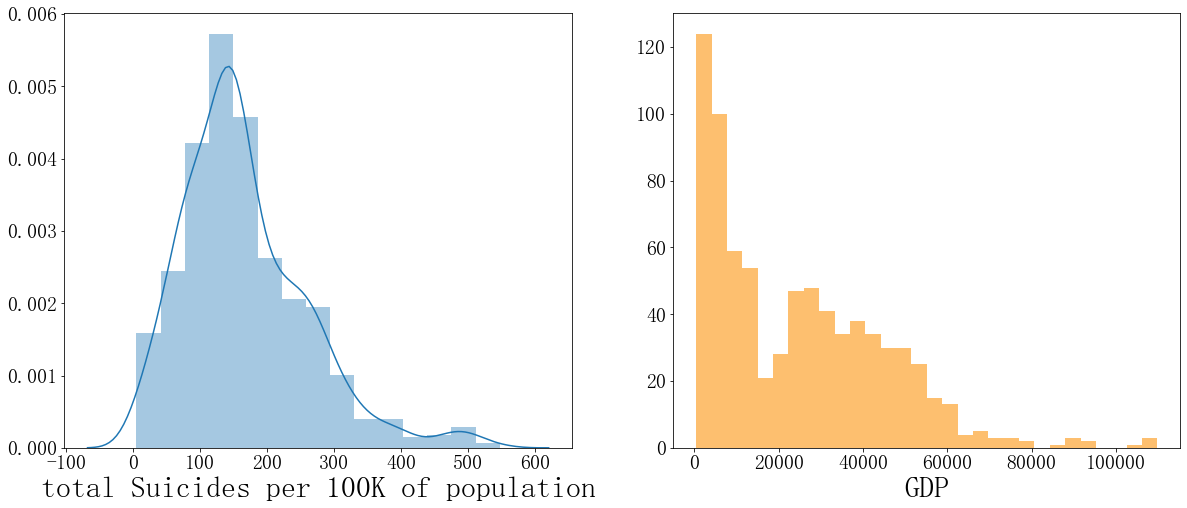

In [21]:
plt.figure(figsize=(20, 8))

# 自杀率（扩大1000倍）(按各个国家的各年份（1995-2013年）的自杀率的总和 统计)
plt.subplot(121)
sns.distplot(total.Suicides, bins=15)   #bins：int或list，控制直方图的划分
plt.xlabel('total Suicides per 100K of population', fontsize=30)
plt.xticks(rotation = 0,fontsize = 20)  
plt.yticks(fontsize = 20)   

plt.subplot(122)
plt.hist(total.GDPpcapita, bins=30, color=col[7])
plt.xlabel('GDP', fontsize=30)
plt.xticks(rotation = 0,fontsize = 20)  
plt.yticks(fontsize = 20)   
plt.show()

In [22]:
# 为了更直观的看出total的数据
total.head(50)

,year,GDPpyear,GDPpcapita,employeecompensation,Unemployment,Lifeexpectancy,Refugees,Selfemployed,Internetusers,Suicides,population,country
0,1995,2.580320e+11,8232,17.243447,18.799999,72.651000,330.0,1.409000,0.086277,119.97,31345400,Argentina
1,1996,2.721500e+11,8563,16.401037,17.110001,72.843000,217.0,1.665000,0.141955,118.03,31780700,Argentina
2,1997,2.928590e+11,9057,16.412140,14.820000,73.029000,159.0,1.541000,0.280340,111.40,32333781,Argentina
3,1998,2.989480e+11,9126,15.014755,12.650000,73.213000,142.0,1.326000,0.830767,116.93,32757259,Argentina
4,1999,2.835230e+11,8546,15.078509,14.050000,73.396000,586.0,1.355000,3.284482,117.19,33174862,Argentina
5,2000,2.842040e+11,8462,14.694699,15.000000,73.576000,609.0,1.154000,7.038683,131.39,33585533,Argentina
6,2001,2.686970e+11,7900,14.238719,17.320000,73.755000,659.0,1.092000,9.780807,143.56,34010946,Argentina
7,2002,9.772400e+10,2840,11.344743,19.590000,73.932000,771.0,1.114000,10.882124,139.42,34407507,Argentina
8,2003,1.275870e+11,3668,11.670367,15.360000,74.107000,784.0,1.657000,11.913697,146.29,34785907,Argentina
9,2004,1.646580e+11,4683,11.506018,13.522000,74.280000,796.0,1.308000,16.036684,131.06,35162945,Argentina


**这里可以看出自杀率为正态分布了**

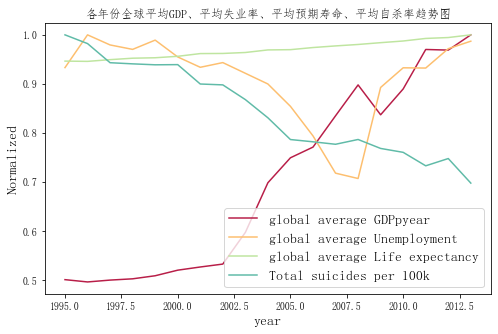

In [23]:
plt.figure(figsize=(8, 5))

# suicides：“GDP年度国内生产总值（美元）”，“雇员补偿%”，“失业人数%”，“预期寿命” 按“年份”分组
suicides = df[['year', 'GDPpyear', 'Selfemployed', 'Unemployment', 'Lifeexpectancy']].groupby('year').mean()

# suicides['Suicides'] 为各年份的自杀率总数
suicides['Suicides'] = df[['country', 'year', 'suicidesper100k']].groupby('year').sum()

# suicides.index ：从1995到2013年，   
# GDPpyear/suicides.GDPpyear.max()  ： GDP年度国内生产总值/最大GDP年度国内生产总值
plt.plot(suicides.index, suicides.GDPpyear/suicides.GDPpyear.max(), color=col[1])  

# suicides.Unemployment：失业总人数(占劳动力总数的百分比)(模拟劳工组织估计数)
# suicides.Unemployment.max()：最大值
plt.plot(suicides.index, suicides.Unemployment/suicides.Unemployment.max(), color=col[7])

# suicides.Lifeexpectancy  ； 各年的预期寿命
plt.plot(suicides.index, suicides.Lifeexpectancy/suicides.Lifeexpectancy.max(), color=col[14])

# suicides.Suicides ：各年的自杀率
plt.plot(suicides.index, suicides.Suicides/suicides.Suicides.max(), color=col[17])

plt.legend(
            ['global average GDPpyear',                            #红线
            'global average Unemployment',                         #黄线
            'global average Life expectancy',                      #绿线
            'Total suicides per 100k'], fontsize=14, loc='best'    #蓝线
            )
plt.ylabel('Normalized', fontsize=14)
plt.xlabel('year', fontsize=14)
plt.title("各年份全球平均GDP、平均失业率、平均预期寿命、平均自杀率趋势图")
plt.show()

**这里的指标**： 
+ 红线：全球平均GDP年度国内生产总值（美元）
+ 黄线：全球平均失业率
+ 绿线：全球平均预期寿命
+ 蓝线：全球平均自杀率

**从图中可以看出**
自1995 - 2013年，

1. 全球的GDP不断上涨，1995年到2000年缓慢上涨，2000年以后经济增长的势头更强；受到金融危机的影响，2008年经济下滑后又开始增长。
2. 全球的失业率也随经济，社会发展，1995-2008逐年降低，之后又攀升。
3. 全球的人预期寿命也随着经济的不断发展逐年上升，人民生活水平提高。
4. 全球的整体自杀率是呈下降趋势的，背后的原因可能是社会的安稳，国家政府的干预，各国政府在医疗保健上的投入和家庭护理的提升。

## 接下来，计算所有选定特征的相关性

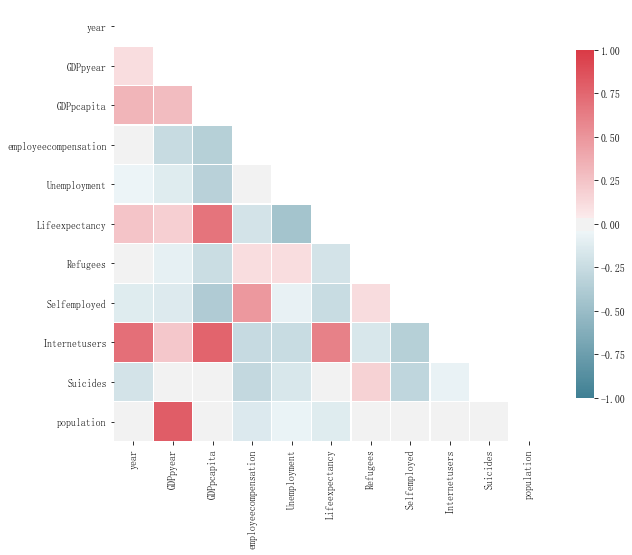

In [24]:
# 热图是数据的图形表示，它使用颜色来传达价值。拥有大量数据时，这是一个很好的工具，可以帮助了解最重要的区域。
# 创建自己的相关矩阵注释热图
# 1.导入数据
# 2.创建关联矩阵
# 3.设置mask隐藏上三角
# 4.在Seaborn中创建热图

#创建相关矩阵
corr = total.corr() #相关系数矩阵，即给出了任意两个变量之间的相关系数

# 相关矩阵的上三角部分与下三角对称。因此，热图不需要显示整个矩阵。在下一步隐藏上三角形。
# 设置mask隐藏上三角
# np.zeros_like() 返回一个零数组，其形状和类型与给定的数组相同。
# 该 dtype=np.bool 参数会覆盖数据类型，因此我们的数组是一个布尔数组。
# np.triu_indices_from(mask) 返回数组上三角形的索引。
# 现在，我们将上三角形设置为True。 mask[np.triu_indices_from(mask)]= True
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 在Seaborn中创建热图
f, ax = plt.subplots(figsize=(10, 8))
# 生成自定义发散颜色图
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# 绘制热图
# 数据为 corr
# vmax,vmin:分别是热力图的颜色取值最大和最小范围
# center:数据表取值有差异时，设置热力图的色彩中心对齐值；通过设置center值，可以调整生成的图像颜色的整体深浅
# square:设置热力图矩阵小块形状，默认值是False
# linewidths(矩阵小块的间隔),
# cbar_kws:热力图侧边绘制颜色刻度条时，相关字体设置，默认值是None
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,  
            square=True, linewidths=0.2, cbar_kws={"shrink": 0.8});


如预期，“因特网用户”特征与国内生产总值特征密切相关。
“预期寿命”与人均GDP也有很强的相关性。
在评估模型输出的特性重要性时，可能要注意到这一点。
其他特征没有显示出很强的相关性。

# 数据预处理

In [25]:
total.describe()

,year,GDPpyear,GDPpcapita,employeecompensation,Unemployment,Lifeexpectancy,Refugees,Selfemployed,Internetusers,Suicides,population
count,768.000000,7.680000e+02,768.000000,668.000000,768.000000,768.000000,757.000000,768.000000,761.000000,768.000000,7.680000e+02
mean,2004.014323,9.252719e+11,24606.537760,15.356784,8.441493,76.117285,15568.048877,3.119477,36.930210,166.217721,3.842748e+07
std,5.488740,2.101423e+12,20375.603419,7.508542,5.073657,5.225005,57993.624563,5.192217,30.085106,94.200243,5.363049e+07
min,1995.000000,1.468317e+09,426.000000,2.891704,0.489000,53.444000,1.000000,0.041000,0.000092,4.950000,2.447000e+05
25%,1999.000000,1.097512e+11,6148.250000,10.143090,5.095750,73.711585,32.000000,0.506000,7.388924,100.125000,6.906944e+06
50%,2004.000000,2.592840e+11,22092.000000,13.967510,7.525500,77.678049,215.000000,1.066000,31.650939,149.100000,1.449888e+07
75%,2009.000000,7.009715e+11,38492.750000,20.118837,10.170000,79.785976,2174.000000,2.875750,64.430000,217.175000,4.798588e+07
max,2013.000000,1.669150e+13,109804.000000,48.962685,33.473000,83.331951,551744.000000,31.235001,96.546800,547.380000,2.953229e+08


In [26]:
# 查看数据确实情况
print('数据集缺失情况如下：\r\n列名     |   缺失数量\r\n{}'.format(total.isnull().sum()))

数据集缺失情况如下：
列名     |   缺失数量
year                      0
GDPpyear                  0
GDPpcapita                0
employeecompensation    100
Unemployment              0
Lifeexpectancy            0
Refugees                 11
Selfemployed              0
Internetusers             7
Suicides                  0
population                0
country                   0
dtype: int64


In [27]:
# 对使用互联网的个人(占人口的百分比) 用最小值填充 在原数据直接修改
total.Internetusers.fillna(total.Internetusers. min(), inplace=True)

# 对难民人口用8填充
total.Refugees.fillna(total.Refugees. min(), inplace=True)

#对雇员补偿(占开支的百分比)用均值填充
total.employeecompensation.fillna(total.employeecompensation.mean(), inplace=True)

# 对总人口用均值填充
total.population.fillna(total.population.mean(), inplace=True)

In [28]:
#查看填充结果
print('数据集缺失情况如下：\r\n列名     |   缺失数量\r\n{}'.format(total.isnull().sum()))

数据集缺失情况如下：
列名     |   缺失数量
year                    0
GDPpyear                0
GDPpcapita              0
employeecompensation    0
Unemployment            0
Lifeexpectancy          0
Refugees                0
Selfemployed            0
Internetusers           0
Suicides                0
population              0
country                 0
dtype: int64


## 自杀风险的二元分类

对自杀数据进行二元分类，根据 自杀率（扩大1000倍） 作为高/低自杀风险来划分风险等级。
在“total”data frame中添加一个额外的列作为‘risk’。

* Suicides < mean(Suicides) --> 低风险 --> class 0
* Suicides > mean(Suicides) --> 高风险 --> class 1

In [29]:
total.head(10)

,year,GDPpyear,GDPpcapita,employeecompensation,Unemployment,Lifeexpectancy,Refugees,Selfemployed,Internetusers,Suicides,population,country
0,1995,2.580320e+11,8232,17.243447,18.799999,72.651,330.0,1.409,0.086277,119.97,31345400,Argentina
1,1996,2.721500e+11,8563,16.401037,17.110001,72.843,217.0,1.665,0.141955,118.03,31780700,Argentina
2,1997,2.928590e+11,9057,16.412140,14.820000,73.029,159.0,1.541,0.280340,111.40,32333781,Argentina
3,1998,2.989480e+11,9126,15.014755,12.650000,73.213,142.0,1.326,0.830767,116.93,32757259,Argentina
4,1999,2.835230e+11,8546,15.078509,14.050000,73.396,586.0,1.355,3.284482,117.19,33174862,Argentina
5,2000,2.842040e+11,8462,14.694699,15.000000,73.576,609.0,1.154,7.038683,131.39,33585533,Argentina
6,2001,2.686970e+11,7900,14.238719,17.320000,73.755,659.0,1.092,9.780807,143.56,34010946,Argentina
7,2002,9.772400e+10,2840,11.344743,19.590000,73.932,771.0,1.114,10.882124,139.42,34407507,Argentina
8,2003,1.275870e+11,3668,11.670367,15.360000,74.107,784.0,1.657,11.913697,146.29,34785907,Argentina
9,2004,1.646580e+11,4683,11.506018,13.522000,74.280,796.0,1.308,16.036684,131.06,35162945,Argentina


In [30]:
# 小于平均值的为低风险，大于平均值的为高风险
total['risk'] = total.Suicides.copy()
total['risk'] = np.where(total.risk < total.Suicides.mean(), 0, 1)

In [31]:
# 风险的平均值
total.Suicides.mean()

166.2177213541667

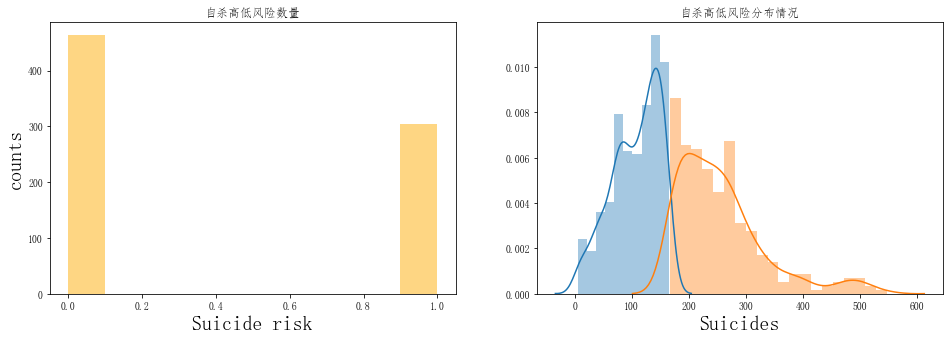

In [32]:
plt.figure(figsize=(16, 5))

plt.subplot(121)
plt.hist(total.risk, color=col[8])
plt.ylabel('counts', fontsize=20)
plt.xlabel('Suicide risk', fontsize=20)
plt.title("自杀高低风险数量")

plt.subplot(122)
sns.distplot(total.Suicides[total.risk == 0], bins=10)
sns.distplot(total.Suicides[total.risk == 1], bins=20)  
plt.xlabel('Suicides', fontsize=20)
plt.title("自杀高低风险分布情况")
plt.show()

由图可以看出自杀率的高低风险的数量及分类情况

### 数据标准化

In [33]:
# 对国家进行 标准化标签，将标签值统一转换成range(标签值个数-1)范围内
# 相当于fit(X).transform(X),意思就是先进行fit(),进行数据拟合，然后在进行transform() 进行标准化处理

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

total.country = le.fit_transform(total.country)  
total.country.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40], dtype=int64)

## 特征选择

In [34]:
# 为建立模型准备数据
# totalfeatures 数据的 11个特征
# array和asarray都可以将结构数据转化为ndarray   
# ndarray是Numpy中的数据结构，是一个多维数组，可以理解为矩阵，具有矢量运算能力，快速、节省空间

X = np.asarray(total[totalfeatures])
y = np.asarray(total['risk'])

# 对数据应用标准定标器，因为ML算法的工作假设是数据是正态分布的
# 标准化数据
# sklearn.preprocessing.StandardScaler() 可保存训练集中的均值、方差参数，然后直接用于转换测试集数据。
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

## 划分训练集、测试集和验证集

In [35]:
# 将数据集拆分为训练集和测试集 576行 11个特征
# 首先将该数据3/4作为训练集，1/4作为测试集；再由训练集划分1/5作为验证集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=4)
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.2,random_state=4)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)
print('Test set:', X_valid.shape, y_valid.shape)

Train set: (460, 11) (460,)
Test set: (192, 11) (192,)
Test set: (116, 11) (116,)


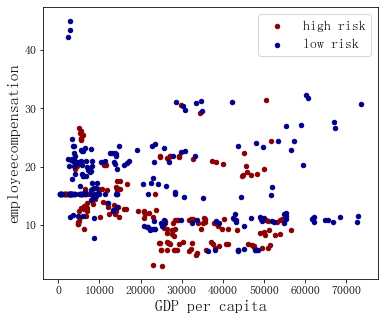

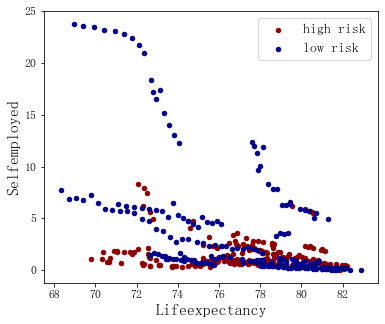

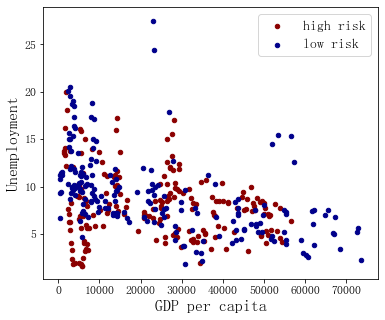

In [36]:
# * Suicides < mean(Suicides) --> 低风险 --> class 0
# * Suicides > mean(Suicides) --> 高风险 --> class 1

# 散点图 是统计可视化的重要组成部分。
# 它使用点云来描述两个变量的联合分布，其中每个点代表数据集中的一个观察。
# 这种描绘可以推断出大量关于它们之间是否有任何有意义的关系的信息。
# [0:200]取0到200的数据
# 人均国内生产总值(美元) 和 雇员的报酬（工资）(占开支的百分比) 的 高低风险

# GDP = 雇员报酬 + 固定资产消耗 + 生产税和进口税净额 + 营业盈余
# 这里面的“雇员报酬”仅仅只是GDP其中的一个组成部分
ax1 = total[total['risk'] == 1][0:200].plot(kind='scatter', x='GDPpcapita', y='employeecompensation', color='DarkRed',
                                            label='high risk', figsize=(6, 5), fontsize=12)
total[total['risk'] == 0][0:200].plot(kind='scatter', x='GDPpcapita', y='employeecompensation', color='DarkBlue',
                                            label='low risk', ax=ax1)

plt.ylabel('employeecompensation', fontsize=16)
plt.xlabel('GDP per capita', fontsize=16)
plt.legend(fontsize=14)


# 预期寿命 和 贡献型家庭工人总人数(占总就业人数的百分比) 的高低风险
ax1 = total[total['risk'] == 1][0:200].plot(kind='scatter', x='Lifeexpectancy', y='Selfemployed', color='DarkRed',
                                            label='high risk', figsize=(6, 5), fontsize=12)
total[total['risk'] == 0][0:200].plot(kind='scatter', x='Lifeexpectancy', y='Selfemployed', color='DarkBlue',
                                            label='low risk', ax=ax1);

plt.ylabel('Selfemployed', fontsize=16)
plt.xlabel('Lifeexpectancy', fontsize=16)
plt.legend(fontsize=14)


# 人均国内生产总值(美元) 和 失业总人数(占劳动力总数的百分比) 的高低风险
ax1 = total[total['risk'] == 1][0:200].plot(kind='scatter', x='GDPpcapita', y='Unemployment', color='DarkRed',
                                            label='high risk', figsize=(6, 5), fontsize=12);
total[total['risk'] == 0][0:200].plot(kind='scatter', x='GDPpcapita', y='Unemployment', color='DarkBlue',
                                            label='low risk', ax=ax1);

plt.ylabel('Unemployment', fontsize=16)
plt.xlabel('GDP per capita', fontsize=16)
plt.legend(fontsize=14)
plt.show()

**图1为 人均GDP 和 雇员的报酬（工资）(占开支的百分比) 的关于自杀率高低的一个分类。**

  雇员的报酬（工资） 是 人均GDP 的一部分，
  人均gdp集中在5000-50000美元；而工资占开销的 10%-30%，
  在人均gdp大致相同的情况下，工资越高，那么自杀率相对会低，但是即使人均gdp很高的情况下，工资如果很低，自杀率也会偏高。

**图2为 预期寿命 和 供养家庭职工总人数(占总就业人数的百分比) 的高低风险**

  预期寿命分布在70-82岁，而在预期寿命相同的情况下，若供养家庭职工总人数多，则自杀风险相对会低
  
**图3为 人均国内生产总值(美元) 和 失业总人数(占劳动力总数的百分比) 的高低风险**

  人均gdp越高，自杀率还是较低的；在人均gdp较低（0-15000美元）下，失业的人数反而不算高；
  但在中产和富裕阶级中，失业人数越高，自杀风险更大。

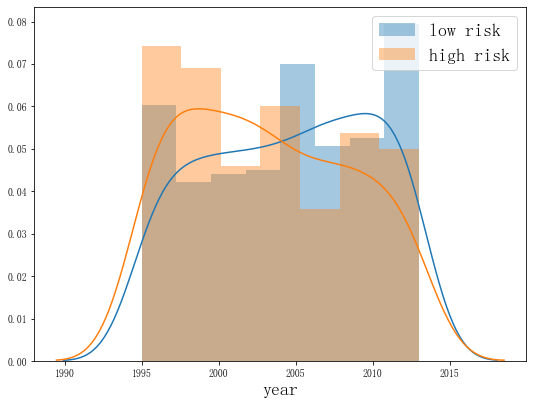

In [37]:
# 关于年份的高低自杀风险
fig = plt.figure(figsize=(30, 30))

plt.subplot(4, 3, 1)
sns.distplot(total[total.columns[0]][total.risk == 0], label='low risk')
sns.distplot(total[total.columns[0]][total.risk == 1], label='high risk')       
plt.legend(loc='best', fontsize=18)  
plt.xlabel(total.columns[0], fontsize=18)
plt.show()

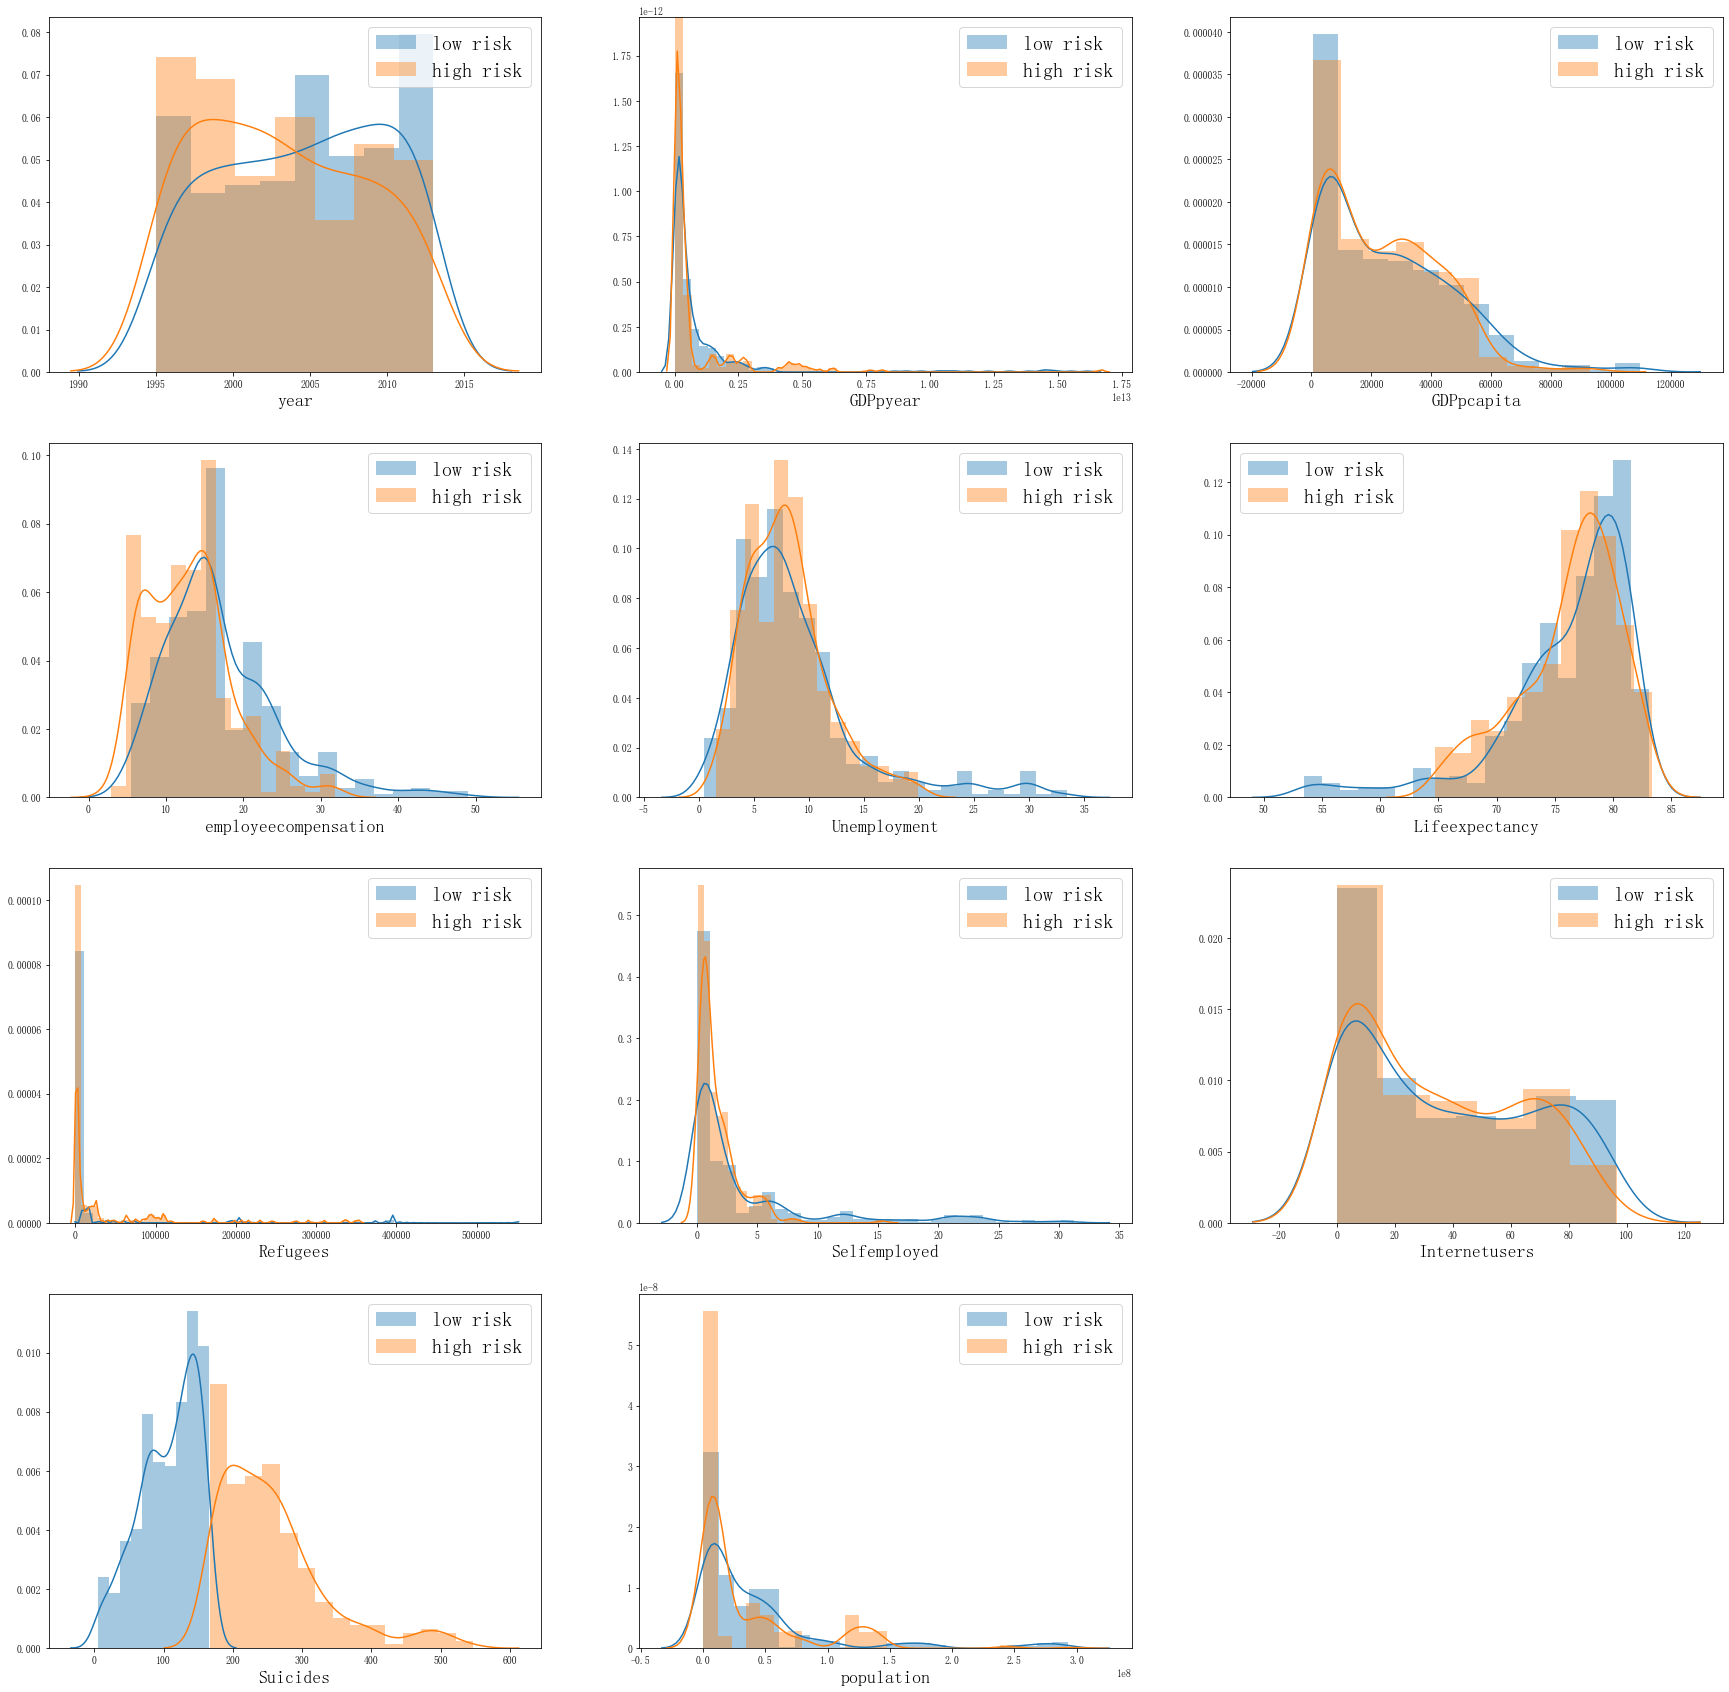

In [38]:
# 所有所选的11个属性的高低风险分布
fig = plt.figure(figsize=(30, 30))

j = 0
for i, x in enumerate(total.columns[0:11]):
    plt.subplot(4, 3, j+1)
    j += 1
    sns.distplot(total[x][total.risk == 0], label='low risk')
    sns.distplot(total[x][total.risk == 1], label='high risk')       
    plt.legend(loc='best', fontsize=20)  
    plt.xlabel(x, fontsize=18)
plt.show()

# 建立模型

In [61]:
# 逻辑回归

# precision_recall_fscore_support 表示的是 计算精确度、召回率、f、支持率
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score,accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, classification_report

LR = LogisticRegression(C=0.001, solver='liblinear').fit(X_train, y_train)

# 预测类别:0还是1
yLRhat = LR.predict(X_valid)
 
# 预测 0或1的概率（例如 [0.54689436, 0.45310564] 预测出来为0）
yLRhat_prob = LR.predict_proba(X_valid)


# 我们并不关注预测的准确率，而是关注在所有的样本当中，自杀风险有没有被全部预测（检测）出来

# 所有正确的预测结果都在对角线上，所以从混淆矩阵中可以很方便直观的看出哪里有错误，因为他们呈现在对角线外面。
# 左上 实际为0 预测为0的  TP
# 右上 实际为1 预测为0的  TN
# 左下 实际为0 预测为1的  FP
# 右下 实际为1 预测为1的  FN
cm = confusion_matrix(y_valid, yLRhat)
print('\n 混淆矩阵： \n', cm)
print('此时模型准确率为:',accuracy_score(y_valid, yLRhat))
print('********************************************************')
print('\n')
print('逻辑回归模型的分类报告\n', classification_report(y_valid, yLRhat))


 混淆矩阵： 
 [[47 21]
 [25 23]]
此时模型准确率为: 0.603448275862069
********************************************************


逻辑回归模型的分类报告
               precision    recall  f1-score   support

           0       0.65      0.69      0.67        68
           1       0.52      0.48      0.50        48

    accuracy                           0.60       116
   macro avg       0.59      0.59      0.59       116
weighted avg       0.60      0.60      0.60       116



**绘制混淆矩阵**

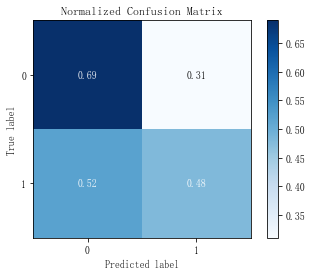

In [40]:
skplt.metrics.plot_confusion_matrix(y_valid,yLRhat,normalize=True)
plt.show()

**交叉验证，找最好的模型参数**

这里的超参数调整我使用网格搜索，因为逻辑回归的超参数较少且模型训练的比较快,而且网格搜索自带就有交叉验证。

In [41]:
from sklearn.model_selection import GridSearchCV

param={"tol":[1e-4, 1e-3,1e-2], "C":[0.4, 0.6, 0.8]}
grid = GridSearchCV(LogisticRegression(),param_grid=param, cv=5)#这里是5折交叉验证
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.best_score_)

#得到最好的逻辑回归分类器
best_LR=grid.best_estimator_ 

#进行训练、预测
best_LR.fit(X_train,y_train)
pred=best_LR.predict(X_valid)

cm = confusion_matrix(y_valid, pred)
print('\n confusion matrix：混淆矩阵 \n', cm)
print('最好的逻辑回归模型准确率为:',accuracy_score(y_valid, pred))
print('********************************************************')
print('\n')
print('最好的逻辑回归模型的分类报告\n', classification_report(y_valid, pred))

{'C': 0.4, 'tol': 0.0001}
0.7130434782608694

 confusion matrix：混淆矩阵 
 [[48 20]
 [19 29]]
最好的逻辑回归模型准确率为: 0.6637931034482759
********************************************************


最好的逻辑回归模型的分类报告
               precision    recall  f1-score   support

           0       0.72      0.71      0.71        68
           1       0.59      0.60      0.60        48

    accuracy                           0.66       116
   macro avg       0.65      0.66      0.65       116
weighted avg       0.66      0.66      0.66       116



**发现逻辑回归对这个分类的效果并不理想，再来看看决策树的分类效果**

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# 决策树学习
# 函数为创建一个决策树模型
# criterion：gini或者entropy,前者是基尼系数，后者是信息熵。
# max_depth：  int or None, optional (default=None) 设置决策随机森林中的决策树的最大深度，深度越大，越容易过拟合，推荐树的深度为：5-20之间。
# max_leaf_nodes： 通过限制最大叶子节点数，可以防止过拟合，默认是"None”，即不限制最大的叶子节点数。
DT = DecisionTreeClassifier(criterion="entropy", max_depth=7, max_leaf_nodes=30)
DT.fit(X_train, y_train)
ydthat = DT.predict(X_valid)

print('***决策树模型***')

#决策树模型性能评估
print('验证集上的准确率:', DT.score(X_valid, y_valid))
print('训练集上的准确率:', DT.score(X_train, y_train))

# 混淆矩阵
print('CM\n', confusion_matrix(y_valid, ydthat))
print('********************************************************')

print('决策树模型的分类报告\n', classification_report(y_valid, ydthat))

DTfeat_importance = DT.feature_importances_
DTfeat_importance = pd.DataFrame([totalfeatures, DT.feature_importances_]).T

# 特征重要性排序
print("特征重要性排名如下:")
print(f'\n一共有{DT.n_features_}个特征')
print(DTfeat_importance.sort_values(by=1, ascending=False))

***决策树模型***
验证集上的准确率: 0.9224137931034483
训练集上的准确率: 0.9782608695652174
CM
 [[66  2]
 [ 7 41]]
********************************************************
决策树模型的分类报告
               precision    recall  f1-score   support

           0       0.90      0.97      0.94        68
           1       0.95      0.85      0.90        48

    accuracy                           0.92       116
   macro avg       0.93      0.91      0.92       116
weighted avg       0.92      0.92      0.92       116

特征重要性排名如下:

一共有11个特征
                       0          1
0                country   0.214271
7               Refugees    0.20339
8           Selfemployed   0.177753
4   employeecompensation   0.150703
10            population   0.133143
2               GDPpyear    0.04646
9          Internetusers  0.0280193
3             GDPpcapita  0.0239414
5           Unemployment  0.0223188
1                   year          0
6         Lifeexpectancy          0


**验证集准确率低于训练集准确率，存在过拟合**
## 所以同样的，我们也用网格搜索找决策树模型的最优超参数

由于决策树的超参数较多，且网格搜索只能基于cpu计算，所以我们不能设置太多。否则会容易导致电脑死机或者是计算时间过于久（设备限制）

In [43]:
param= {'criterion':['gini','entropy'],'max_depth':[5,7,10,15,20],'max_leaf_nodes':[5,10,20,30,40],'min_samples_leaf':[1,3,5,7,9]}
grid=GridSearchCV(DecisionTreeClassifier(),param_grid=param,cv=6)#使用6折交叉验证
grid.fit(X_train,y_train)

print('最优超参数:',grid.best_params_)
print('最优分数:', grid.best_score_)

#得到最好的决策树分类器
best_DT=grid.best_estimator_ 

#进行训练、预测
best_DT.fit(X_train,y_train)
pred=best_DT.predict(X_valid)

#决策树模型性能评估
print('验证集上的准确率:', best_DT.score(X_valid, y_valid))
print('训练集上的准确率:', best_DT.score(X_train, y_train))


cm = confusion_matrix(y_valid, pred)
print('\n confusion matrix：混淆矩阵 \n', cm)
print('网格搜索最好的决策树模型准确率为:',accuracy_score(y_valid, pred))
print('********************************************************')
print('\n')
print('网格搜索最好的决策树模型的分类报告\n', classification_report(y_valid, pred))

最优超参数: {'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': 40, 'min_samples_leaf': 1}
最优分数: 0.9173501936659831
验证集上的准确率: 0.9051724137931034
训练集上的准确率: 0.9956521739130435

 confusion matrix：混淆矩阵 
 [[62  6]
 [ 5 43]]
网格搜索最好的决策树模型准确率为: 0.9051724137931034
********************************************************


网格搜索最好的决策树模型的分类报告
               precision    recall  f1-score   support

           0       0.93      0.91      0.92        68
           1       0.88      0.90      0.89        48

    accuracy                           0.91       116
   macro avg       0.90      0.90      0.90       116
weighted avg       0.91      0.91      0.91       116



**可以看出依然存在过拟合的问题，究其原因，因为决策树的分类依据就是每个分支，所以一旦树的深度和叶子数多，则必然会在训练集上表现优异，从而也就导致了过拟合，所以我们不能仅仅依赖网格搜索来找决策树的最优参数，而是应该画图，找到不同参数下模型分数的拐点作为最优参数以减少过拟合**

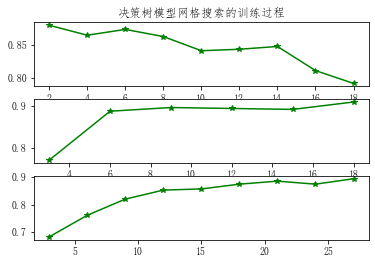

In [44]:
# 通过cv_results观察过程并做图
max_depth=np.arange(0,20,3)
max_leaf_nodes=np.arange(0,30,3)
min_samples_leaf =np.arange(0,20,2)
param1= {'criterion':['entropy'],'max_depth':max_depth}
param2= {'criterion':['entropy'],'min_samples_leaf':min_samples_leaf}
param3= {'criterion':['entropy'],'max_leaf_nodes':max_leaf_nodes}


clf1 = GridSearchCV(DecisionTreeClassifier(),param_grid=param1,cv=6)
clf1.fit(X_train,y_train)

clf2 = GridSearchCV(DecisionTreeClassifier(),param_grid=param2,cv=6)
clf2.fit(X_train,y_train)


clf3 = GridSearchCV(DecisionTreeClassifier(),param_grid=param3,cv=6)
clf3.fit(X_train,y_train)



fig = plt.figure()
ax = fig.add_subplot(311)
ax.plot(min_samples_leaf,clf2.cv_results_['mean_test_score'],'g*-')
plt.title('决策树模型网格搜索的训练过程')


ax = fig.add_subplot(312)
ax.plot(max_depth,clf1.cv_results_['mean_test_score'],'g*-')

ax = fig.add_subplot(313)
ax.plot(max_leaf_nodes,clf3.cv_results_['mean_test_score'],'g*-')
plt.show()

**从图中可以看出对应最好的参数分别为4,12,25,用这些数值构造最好的决策树模型**

In [45]:
best_DT = DecisionTreeClassifier(criterion="entropy", max_depth=15, max_leaf_nodes=25,min_samples_leaf=4)
best_DT.fit(X_train, y_train)
ydthat =best_DT.predict(X_valid)

print('***决策树模型***')

#决策树模型性能评估
print('验证集上的准确率:',best_DT.score(X_valid, y_valid))
print('训练集上的准确率:',best_DT.score(X_train, y_train))

# 混淆矩阵
print('CM\n', confusion_matrix(y_valid, ydthat))
print('********************************************************')

print('决策树模型的分类报告\n', classification_report(y_valid, ydthat))

DTfeat_importance = best_DT.feature_importances_
DTfeat_importance = pd.DataFrame([totalfeatures, DT.feature_importances_]).T

# 特征重要性排序
print("特征重要性排名如下:")
print(f'\n一共有{best_DT.n_features_}个特征')
print(DTfeat_importance.sort_values(by=1, ascending=False))

***决策树模型***
验证集上的准确率: 0.9224137931034483
训练集上的准确率: 0.9652173913043478
CM
 [[65  3]
 [ 6 42]]
********************************************************
决策树模型的分类报告
               precision    recall  f1-score   support

           0       0.92      0.96      0.94        68
           1       0.93      0.88      0.90        48

    accuracy                           0.92       116
   macro avg       0.92      0.92      0.92       116
weighted avg       0.92      0.92      0.92       116

特征重要性排名如下:

一共有11个特征
                       0          1
0                country   0.214271
7               Refugees    0.20339
8           Selfemployed   0.177753
4   employeecompensation   0.150703
10            population   0.133143
2               GDPpyear    0.04646
9          Internetusers  0.0280193
3             GDPpcapita  0.0239414
5           Unemployment  0.0223188
1                   year          0
6         Lifeexpectancy          0


**这里可以看出训练集与验证集上准确率差异变小，也就提高了模型的泛化能力**

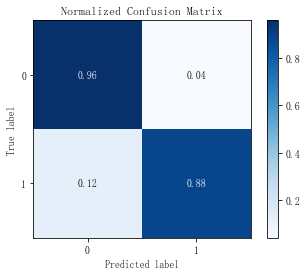

In [46]:
# 决策树模型的混淆矩阵
skplt.metrics.plot_confusion_matrix(y_valid,ydthat,normalize=True)
plt.show()

**得出精确率 召回率 F1的指标以及特征重要性。**

以ROC曲线下面积作为度量

  AUC（Area Under Curve）就是ROC曲线下的面积。
  首先AUC值是一个概率值，当你随机挑选一个正样本以及一个负样本，当前的分类算法根据计算得到的Score值将这个正样本排在负样本前面的概率，就是AUC值。当然，AUC值越大，当前的分类算法越有可能将正样本排在负样本前面，即能够更好的分类。
  
  AUC值越大的分类器，正确率越高。
  为什么还要使用ROC和AUC呢？因为ROC曲线有个很好的特性：当测试集中的正负样本的分布变化的时候，ROC曲线能够保持不变。 

In [48]:
from sklearn.metrics import roc_curve, auc

#真正例（True Positive Rate，TPR），表示所有正例中，预测为正例的比例
#假正例（False Positive Rate，FPR），表示所有负例中，预测为正例的比例

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, ydthat)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9154411764705883

In [49]:
# 随机森林可以视为多颗决策树的集成，鲁棒性更强，泛化能力更好，不易产生过拟合现象。但是噪声比较大的情况下会过拟合。

from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=20, max_depth=10, min_samples_split=2, min_samples_leaf=5,
                                       max_leaf_nodes=20, max_features=len(totalfeatures)) 

random_forest.fit(X_train, y_train)

yrfhat = random_forest.predict(X_valid)
feat_importance = random_forest.feature_importances_
rffeat_importance = pd.DataFrame([totalfeatures, random_forest.feature_importances_]).T

print('******************Random forest classifier**************')
print('训练集上的准确率', random_forest.score(X_train, y_train))
print('验证集上的准确率', random_forest.score(X_valid,y_valid))
print('混淆矩阵\n', confusion_matrix(y_valid, yrfhat))
print('********************************************************')
print('随机森林的分类报告\n', classification_report(y_valid, yrfhat))
print(rffeat_importance.sort_values(by=1, ascending=False))

******************Random forest classifier**************
训练集上的准确率 0.9586956521739131
验证集上的准确率 0.8879310344827587
混淆矩阵
 [[62  6]
 [ 7 41]]
********************************************************
随机森林的分类报告
               precision    recall  f1-score   support

           0       0.90      0.91      0.91        68
           1       0.87      0.85      0.86        48

    accuracy                           0.89       116
   macro avg       0.89      0.88      0.88       116
weighted avg       0.89      0.89      0.89       116

                       0          1
8           Selfemployed   0.180005
7               Refugees   0.173754
0                country   0.168169
4   employeecompensation   0.167287
10            population   0.126147
2               GDPpyear  0.0583718
5           Unemployment  0.0515743
9          Internetusers  0.0331594
3             GDPpcapita  0.0159854
1                   year  0.0151735
6         Lifeexpectancy  0.0103742


### 我们对随机森林模型也进行超参数搜索

In [50]:
#我们首先对n_estimators进行网格搜索：
param_test1 = {'n_estimators':[50,120,160,200,250]}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_test1,cv=5)
gsearch1.fit(X_train,y_train)
print( gsearch1.best_params_, gsearch1.best_score_)

{'n_estimators': 160} 0.9369565217391305


In [51]:
#接着我们对决策树最大深度max_depth和内部节点再划分所需最小样本数min_samples_split进行网格搜索。
param_test2 = {'max_depth':[1,2,3,5,7,9,11,13,20],'min_samples_split':[5,10,25,50,100,120,150]}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=200),param_grid = param_test2, cv=5)
gsearch2.fit(X_train,y_train)
print( gsearch2.best_params_, gsearch2.best_score_)

{'max_depth': 13, 'min_samples_split': 5} 0.9304347826086957


In [52]:
#最好的随机森林模型
best_rf=RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=10) 

best_rf .fit(X_train, y_train)

yrfhat = best_rf .predict(X_valid)
feat_importance = best_rf.feature_importances_
rffeat_importance = pd.DataFrame([totalfeatures, random_forest.feature_importances_]).T

print('******************随机森林模型**************')
print('训练集上的准确率',best_rf.score(X_train, y_train))
print('验证集上的准确率',best_rf.score(X_valid,y_valid))
print('混淆矩阵\n', confusion_matrix(y_valid, yrfhat))
print('********************************************************')
print('最好的随机森林模型的分类报告\n', classification_report(y_valid, yrfhat))
print(rffeat_importance.sort_values(by=1, ascending=False))

******************随机森林模型**************
训练集上的准确率 0.9826086956521739
验证集上的准确率 0.9482758620689655
混淆矩阵
 [[67  1]
 [ 5 43]]
********************************************************
最好的随机森林模型的分类报告
               precision    recall  f1-score   support

           0       0.93      0.99      0.96        68
           1       0.98      0.90      0.93        48

    accuracy                           0.95       116
   macro avg       0.95      0.94      0.95       116
weighted avg       0.95      0.95      0.95       116

                       0          1
8           Selfemployed   0.180005
7               Refugees   0.173754
0                country   0.168169
4   employeecompensation   0.167287
10            population   0.126147
2               GDPpyear  0.0583718
5           Unemployment  0.0515743
9          Internetusers  0.0331594
3             GDPpcapita  0.0159854
1                   year  0.0151735
6         Lifeexpectancy  0.0103742


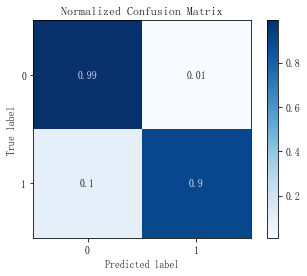

In [53]:
#随机森林模型的混淆矩阵
skplt.metrics.plot_confusion_matrix(y_valid,yrfhat,normalize=True)
plt.show()

**分类性能比较/ROC图**

ROC是以FPR为X轴，以TPR为Y轴的曲线。表示的是模型的效果（由TPR表示）和损失（由FPR代表）的相对关系和取舍概况。 
分类器对不同样本给出了更偏向正例还是反例的的概率值，然后这些概率值可以和一些人为设定的阈值比较从而得出最终的分类结果。例如，大于阈值的就是正例，小于阈值的就是反例。可以看出，不同的阈值设定对最终结果有很大的影响，ROC曲线表示的就是在不同阈值的设定下，分类结果的呈现。

选择最佳的诊断界限值。ROC曲线越靠近左上角,试验的准确性就越高。最靠近左上角的ROC曲线的点是错误最少的最好阈值，其假阳性和假阴性的总数最少。

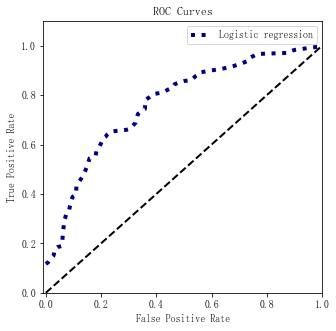

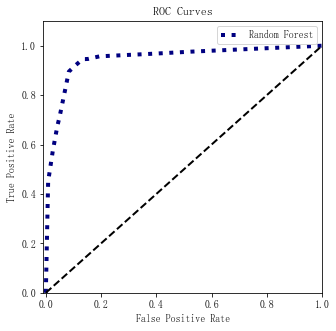

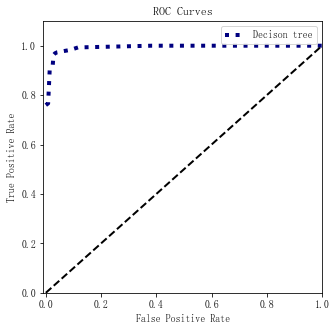

In [54]:
models = [best_LR, best_DT,best_rf]
modelnames = ['Logistic regression',  'Random Forest', 'Decison tree']


for i, x in enumerate(models):
    y_true = y_test
    y_probas = x.predict_proba(X_test)
    ax1 = skplt.metrics.plot_roc(y_true, y_probas, plot_micro=False, plot_macro=True, classes_to_plot=[], figsize=(5, 5))
    plt.axis((-0.01, 1, 0, 1.1))
    plt.legend([modelnames[i]], loc='best')

In [59]:
dtpred=best_DT.predict(X_test)
rfpred=best_rf.predict(X_test)

dt_score=accuracy_score(y_test,dtpred)
rf_score=accuracy_score(y_test,rfpred)

print("决策树在测试集上准确率为:",dt_score)
print("随机森林在测试集上准确率为:",rf_score)

if dt_score>rf_score:
    print("决策树模型是三者中最好的分类模型")
else:
    print("随机森林是三者中最好的分类模型")

决策树在测试集上准确率为: 0.9270833333333334
随机森林在测试集上准确率为: 0.9635416666666666
随机森林是三者中最好的分类模型


**通过比较我们得知了随机森林是三者中最好的分类模型，进而对随机森林中的特征重要程度进行分析，得到结论**

In [56]:
rffeat_importance.columns=['特征','重要程度']
rffeat_importance

,特征,重要程度
0,country,0.168169
1,year,0.0151735
2,GDPpyear,0.0583718
3,GDPpcapita,0.0159854
4,employeecompensation,0.167287
5,Unemployment,0.0515743
6,Lifeexpectancy,0.0103742
7,Refugees,0.173754
8,Selfemployed,0.180005
9,Internetusers,0.0331594


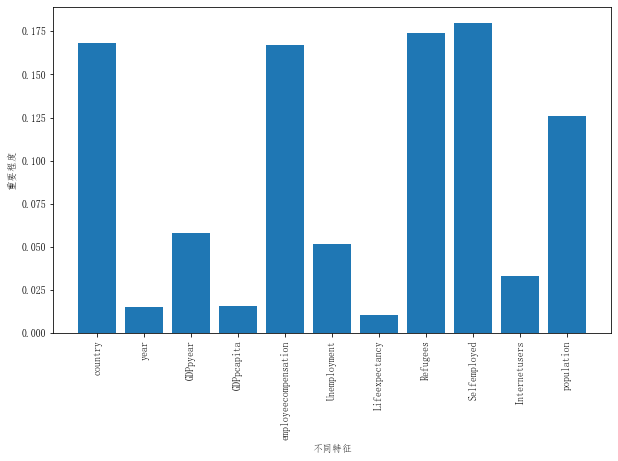

In [58]:
plt.figure(figsize=(10,6))
plt.bar(rffeat_importance['特征'],rffeat_importance['重要程度'])
plt.xticks(rotation=90)
plt.xlabel("不同特征")
plt.ylabel("重要程度")
plt.show()

<hr>

# 分析：

**从上面的条形图中我们可以发现影响自杀率的主要特征是employeecompensation、Selfemployed、Refugees、country、GDPpyear、population**

首先我们的自杀率=自杀人数/总人口数
接下来我们就对这几个特征影响自杀率的原因进行分析：
1. employeecompensation（工资）当工资低，占开支的百分比较少时，也就意味着生活质量很低，从而自杀率升高；
2. Selfemployed（个体经营家庭总人数占比）当个体经营家庭总人数占比高时，就业压力相对较小，所以自杀率较低；
3. Refugees（难民人口）当难民人口较多时，难民生存困难，很有可能就因为各种原因堕落消沉从而导致自杀率升高；
4. country（国家）发达国家的人民生活节奏快，竞争压力大，失业率高，所以自杀率高；
5. GDPpyear（国家的年度生产总值）经济发展快速的国家，也就有更大的就业竞争压力，从而GDPpyear高的国家自杀率高；
6. population（人口数量）由于我们计算的是自杀率，从而人口数量也是一个影响因素；当具有相同自杀人数时，人口总数越高，自杀率越低；而人口基数大时，相对的自杀率也会上升。

# 总结：

对于一个国家来说

+ 当人们工资少，那么自杀率会升高（最重要！！！也说明了物质社会人们对于物质的需求还是很渴望的）
+ 当每个家庭和睦、家庭氛围好，家庭压力小，那么自杀率会降低
+ 当难民较多，那么自杀率会升高
+ 当国家越发达，GDP越高，那么生活节奏飞快，生活代价很高,失业率严重、人际关系紧张等，从而导致自杀率高
+ 对于人口数量多的国家，自杀人数处于正态分布，当人口数量足够大时，相应的自杀率也就很小

全球范围内，年龄越大的人群自杀率相对较高。在现在全球人口老龄化的趋势下，这种情况无疑更加严峻。关于老年人群的生活的物质条件需要改善，其心理更需要梳理与关注。而男性比起女性来说社会压力更大，从而自杀率也更大，所以公司也应该定期对职员进行心理疏导。

# 不足与改进：

**不足：**

从这次数据分析基本得到了结论，也与实际相符合，但是回顾来看，模型依然是过拟合的，我们只能减小过拟合程度；对于网格搜索的超参数由于各种原因限制，我们也无法实验所有的超参数，从而也无法真正得到最优参数与最优模型，得到的只能是相对较好的，泛化能力较强的模型；但是随机森林作为最好的分类模型，虽然它的受噪音影响小，鲁棒性更强，但是如果数据噪音较大也容易过拟合。

**改进：**
1. 我们可以尝试更多的分类模型，比如：SVM、KNN、MLP或者是更复杂的神经网络
2. 我们可以先对数据特征做处理，比如特征提取（PCA、LDA、SVD），特征提取（Filter、Wrapper、Embedded），或者基于不纯度的减少量作为指标，得到最主要的特征再进行建模
3. 加入更多的超参数进行搜索，得到更贴近最好的分类模型